In [1]:

from collections import defaultdict
from pathlib import Path
from typing import List, Tuple, Dict, Iterator, Callable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [2]:
save_path = Path('images/results')
save_path.mkdir(parents=True, exist_ok=True)
sns.set_theme()
sns.set_palette('muted')

In [3]:
def get_log_identifier(log_path: Path) -> int:
    filename = log_path.stem
    identifier = filename.split('-')[-1]
    return int(identifier)


def iter_over_log_files(path_to_logs: Path) -> Iterator[str]:
    for log_file in sorted(path_to_logs.glob('*-log-epoch-*.log'), key=get_log_identifier):
        yield log_file


def parse_summarization_log(log_path: Path, activate_special: Callable[[str], bool], special_mode: bool) -> \
        Tuple[List[float], List[int], List[float], List[int], float, int, Dict[str, float], bool]:
    steps_list = []
    loss_list = []
    special_steps = []
    special_loss = []
    val_loss = None
    val_step = None
    rouge_scores = {}
    epoch = 0
    iteration_max = 0
    with open(log_path, 'r') as log_file:
        for line in log_file:
            if activate_special(line):
                special_mode = True
                continue

            if 'ROUGE' in line:
                line_split = line.split(', ')
                loss = line_split[2]
                val_loss = float(loss.replace('Loss: ', ''))
                val_step = (epoch + 1) * iteration_max
                for score in line_split[-3:]:
                    score, value = score.split(': ')
                    rouge_scores[score] = float(value)

            if 'Loss' not in line:
                continue
            line_split = line.split(',')
            if len(line_split) != 4:
                continue

            step = line_split[0]
            epoch, iteration = step.split(' Iter: ')
            epoch = int(epoch.replace('Epoch: ', ''))
            iteration, iteration_max = iteration.split('/')
            iteration = int(iteration)
            iteration_max = int(iteration_max)
            loss = line_split[-2].replace('Loss: ', '')
            loss = float(loss)
            if special_mode:
                special_loss.append(loss)
                special_steps.append(epoch * iteration_max + iteration)
            else:
                loss_list.append(loss)
                steps_list.append(epoch * iteration_max + iteration)

    return loss_list, steps_list, special_loss, special_steps, val_loss, val_step, rouge_scores, special_mode


def parse_full_validation_summarization(log_path: Path) -> Tuple[List[float], Dict[str, List[float]]]:
    scores = defaultdict(list)
    loss_list = []
    with open(log_path / f'{log_path.stem}-log-full_eval.log', 'r') as val_file:
        for line in val_file:
            if 'test phase' in line:
                break

            if 'ROUGE' not in line:
                continue

            line_split = line.split(', ')
            loss = line_split[2]
            val_loss = float(loss.replace('Loss: ', ''))
            loss_list.append(val_loss)
            for score in line_split[-3:]:
                score, value = score.split(': ')
                scores[score].append(float(value))

    return loss_list, scores


def get_summarization_performance(path: Path, activate_special: Callable[[str], bool] = lambda _: False,
                                  use_full_validation: bool = False) -> \
        Tuple[List[float], List[int], List[float], List[int], List[float], List[int], Dict[str, float]]:
    special_mode = False
    loss_all = []
    steps_all = []
    coverage_loss_all = []
    coverage_steps_all = []
    val_loss_all = []
    val_steps_all = []
    scores_all = defaultdict(list)
    for log_file in iter_over_log_files(path):
        loss, steps, coverage_loss, coverage_steps, val_loss, val_steps, scores, special_mode = \
            parse_summarization_log(log_file, activate_special, special_mode)
        loss_all += loss
        steps_all += steps
        coverage_loss_all += coverage_loss
        coverage_steps_all += coverage_steps
        val_loss_all.append(val_loss)
        val_steps_all.append(val_steps)
        for score, value in scores.items():
            scores_all[score].append(value)

    if use_full_validation:
        val_loss_all, scores_all = parse_full_validation_summarization(path)

    return loss_all, steps_all, coverage_loss_all, coverage_steps_all, val_loss_all, val_steps_all, scores_all

In [4]:
def plot_pointer_generator_performance(path: Path, dataset: str, use_full_validation: bool = False) -> None:
    train_loss, train_steps, coverage_loss, coverage_steps, val_loss, val_steps, scores = \
        get_summarization_performance(path, activate_special=lambda line: 'coverage' in line,
                                      use_full_validation=use_full_validation)
    fig = plt.figure(figsize=(15, 10))
    grid = GridSpec(2, 2)
    train_ax: plt.Axes = plt.subplot(grid[0, :])
    val_ax: plt.Axes = plt.subplot(grid[1, 0])
    test_ax: plt.Axes = plt.subplot(grid[1, 1])

    train_type = ['Normal training' for _ in train_steps] + ['Training with coverage' for _ in coverage_steps]
    train_data = pd.DataFrame(
        {'Iteration': train_steps + coverage_steps, 'Loss': train_loss + coverage_loss, 'Training type': train_type}
    )
    val_data = {
        'Iteration': val_steps,
        'Loss': val_loss
    }
    test_data = pd.DataFrame(scores)
    test_data['Iteration'] = val_steps
    test_data = test_data.set_index('Iteration')

    train_ax.axvline(x=coverage_steps[0], lw=1, ls='--', c='b', alpha=0.5)
    sns.lineplot(data=train_data, x='Iteration', y='Loss', hue='Training type', ax=train_ax)
    sns.lineplot(data=val_data, x='Iteration', y='Loss', ax=val_ax, color='g')
    sns.lineplot(data=test_data, ax=test_ax)

    fig.suptitle(f'Pointer generator performance on {dataset} dataset.')
    train_ax.set_title('Loss change during training')
    val_ax.set_title('Validation loss change during training')
    test_ax.set_title('ROUGE scores change during training')

    plot_title = dataset.replace(' ', '_').replace('/', '_').lower()
    plt.savefig(f'images/results/pointer_generator_{plot_title}.png')
    plt.show()

In [5]:
def plot_transformer_performance(path: Path, dataset: str, use_full_validation: bool = False) -> None:
    train_loss, train_steps, _, _, val_loss, val_steps, scores = \
        get_summarization_performance(path, use_full_validation=use_full_validation)
    fig = plt.figure(figsize=(15, 10))
    grid = GridSpec(2, 2)
    train_ax: plt.Axes = plt.subplot(grid[0, :])
    val_ax: plt.Axes = plt.subplot(grid[1, 0])
    test_ax: plt.Axes = plt.subplot(grid[1, 1])

    train_data = {
        'Iteration': train_steps,
        'Loss': train_loss
    }
    val_data = {
        'Iteration': val_steps,
        'Loss': val_loss
    }
    test_data = pd.DataFrame(scores)
    test_data['Iteration'] = val_steps
    test_data = test_data.set_index('Iteration')

    sns.lineplot(data=train_data, x='Iteration', y='Loss', ax=train_ax)
    sns.lineplot(data=val_data, x='Iteration', y='Loss', ax=val_ax, color='g')
    sns.lineplot(data=test_data, ax=test_ax)

    fig.suptitle(f'Transformer performance on {dataset} dataset.')
    train_ax.set_title('Loss change during training')
    val_ax.set_title('Validation loss change during training')
    test_ax.set_title('ROUGE scores change during training')

    plot_subtitle = dataset.replace(' ', '_').replace('/', '_').lower()
    plt.savefig(f'images/results/transformer_{plot_subtitle}.png')
    plt.show()

In [6]:
def plot_rl_performance(path: Path, dataset: str, use_full_validation: bool = False) -> None:
    pretrain_loss, pretrain_steps, train_loss, train_steps, val_loss, val_steps, scores = \
        get_summarization_performance(path, activate_special=lambda line: 'pretraining' in line,
                                      use_full_validation=use_full_validation)
    print(val_loss)
    print(val_steps)
    fig = plt.figure(figsize=(15, 10))
    grid = GridSpec(2, 2)
    pretrain_ax: plt.Axes = plt.subplot(grid[0, 0])
    train_ax: plt.Axes = plt.subplot(grid[0, 1])
    val_ax: plt.Axes = plt.subplot(grid[1, 0])
    test_ax: plt.Axes = plt.subplot(grid[1, 1])

    pretrain_data = {
        'Iteration': pretrain_steps,
        'Loss': pretrain_loss
    }
    train_data = {
        'Iteration': train_steps,
        'Loss': train_loss
    }
    val_data = {
        'Iteration': val_steps,
        'Loss': val_loss
    }
    test_data = pd.DataFrame(scores)
    test_data['Iteration'] = val_steps
    test_data = test_data.set_index('Iteration')

    sns.lineplot(data=pretrain_data, x='Iteration', y='Loss', ax=pretrain_ax)
    sns.lineplot(data=train_data, x='Iteration', y='Loss', ax=train_ax, color='r')
    sns.lineplot(data=val_data, x='Iteration', y='Loss', ax=val_ax, color='g')
    sns.lineplot(data=test_data, ax=test_ax)

    fig.suptitle(f'RL model performance on {dataset} dataset.')
    train_ax.set_title('Loss change during pretraining')
    train_ax.set_title('Loss change during training (fine-tuning)')
    val_ax.set_title('Validation loss change during training')
    test_ax.set_title('ROUGE scores change during training')

    plot_subtitle = dataset.replace(' ', '_').replace('/', '_').lower()
    plt.savefig(f'images/results/rl_{plot_subtitle}.png')
    plt.show()

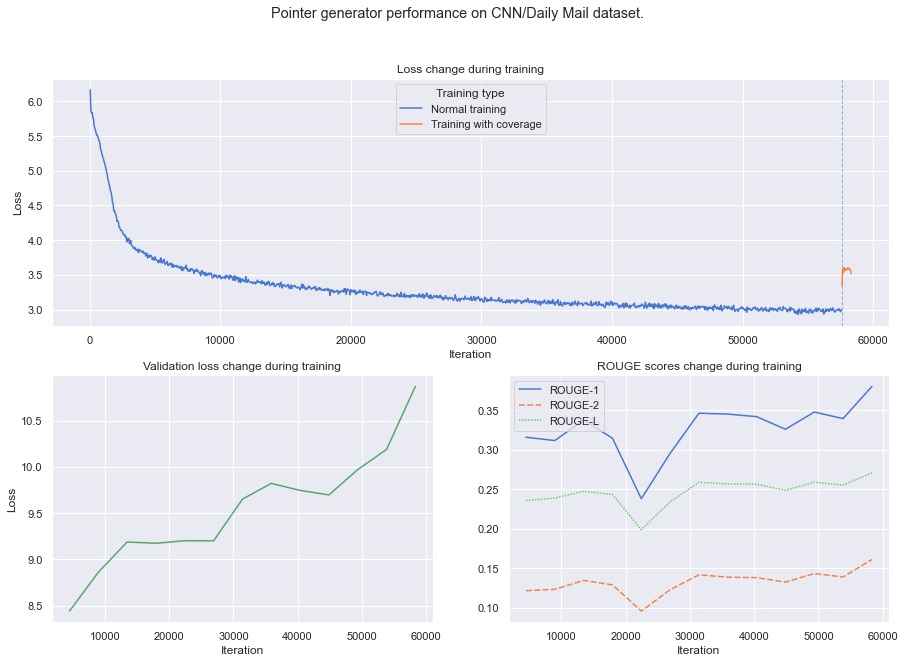

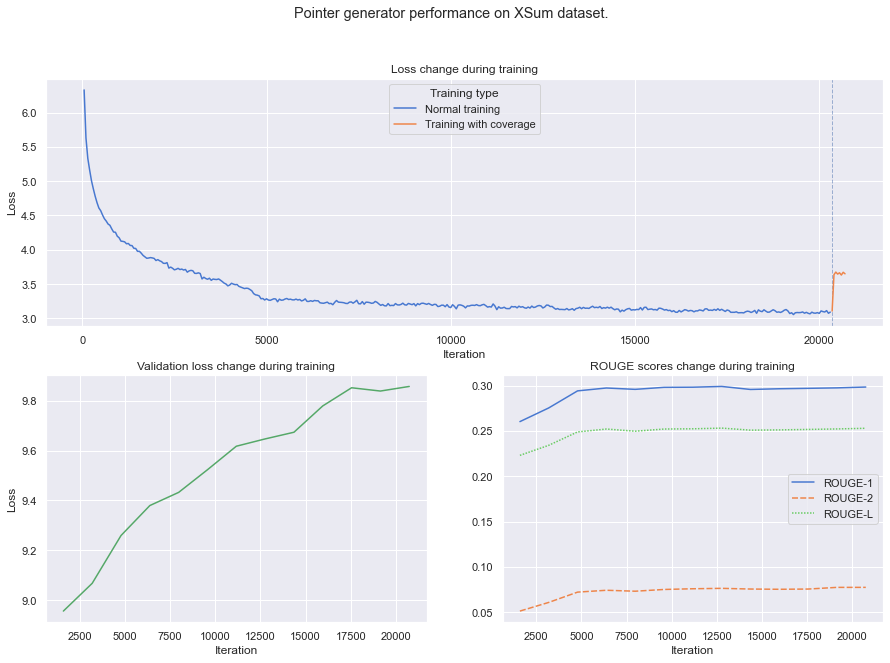

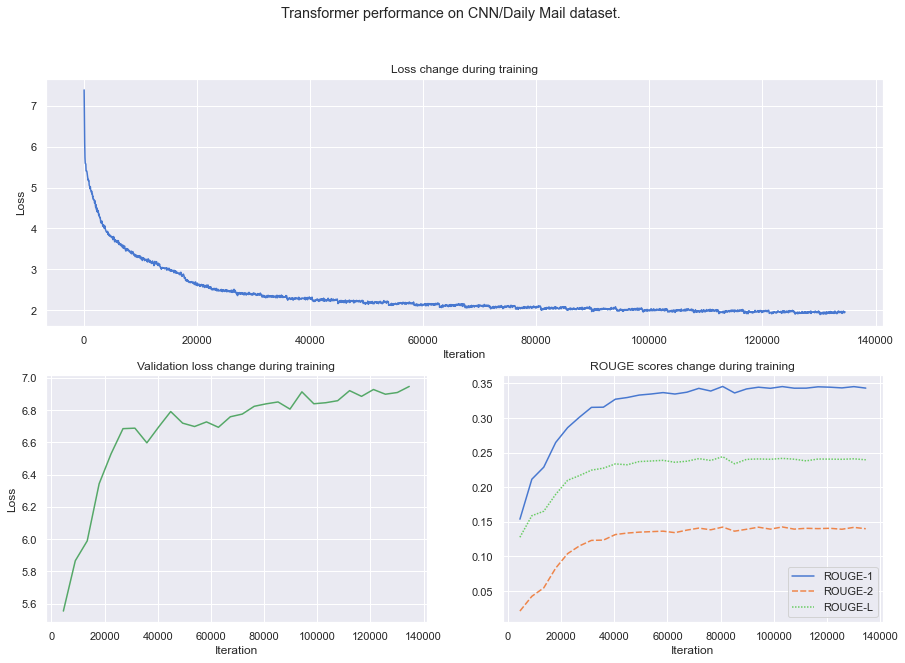

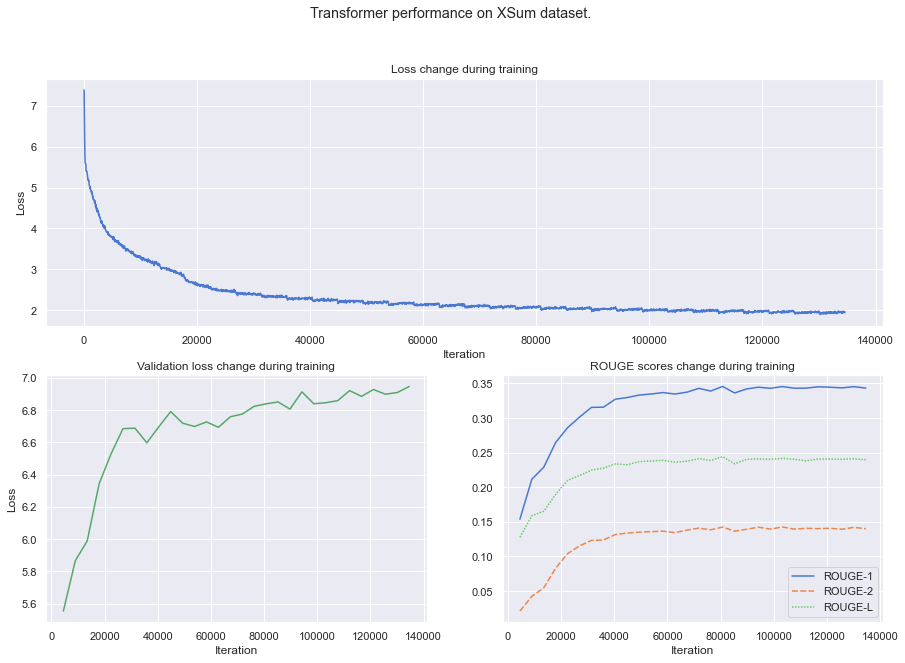

[6.60496171695764, 6.815566653840279, 6.7653622718519, 6.818892937527889, 6.852879369087767, 6.869431262951719, 6.844931426801179, 6.91027542278527, 6.957686378625021, 6.899212862315931, 6.972840829329058, 6.941080095665306, 7.952312020023474, 8.104430787300949, 8.141584131706274, 8.224824750252317, 8.278606414794922, 8.201904483959435, 8.338572196412885, 8.237013492858011]
[4487, 8974, 13461, 17948, 22435, 26922, 31409, 35896, 40383, 44870, 49357, 53844, 58331, 62818, 67305, 71792, 76279, 80766, 85253, 89740]


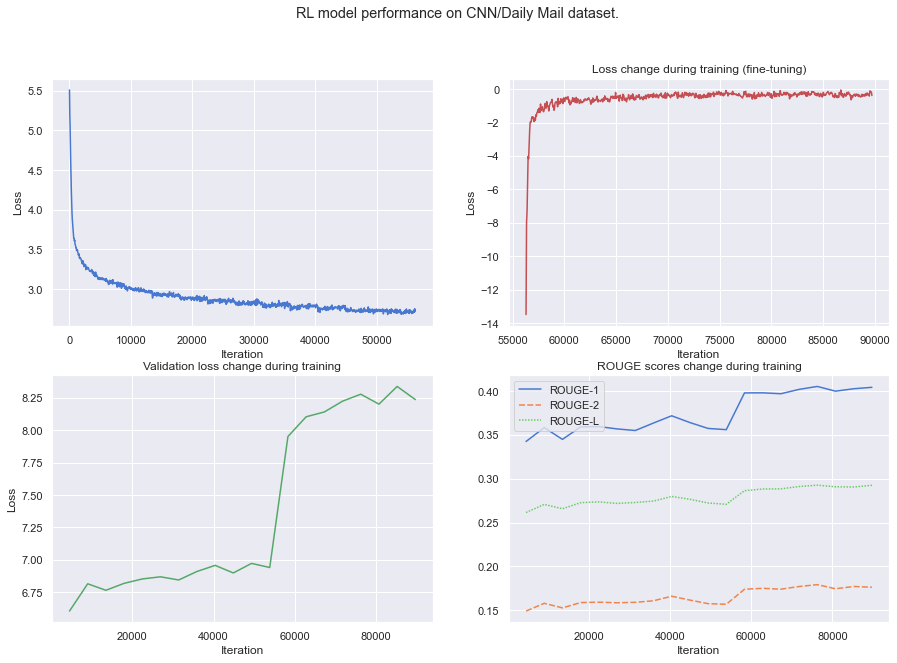

[6.020958364679572, 6.0943110230263695, 7.662468661083264, 7.812663201535686, 7.784693123249525]
[3189, 6378, 9567, 12756, 15945]


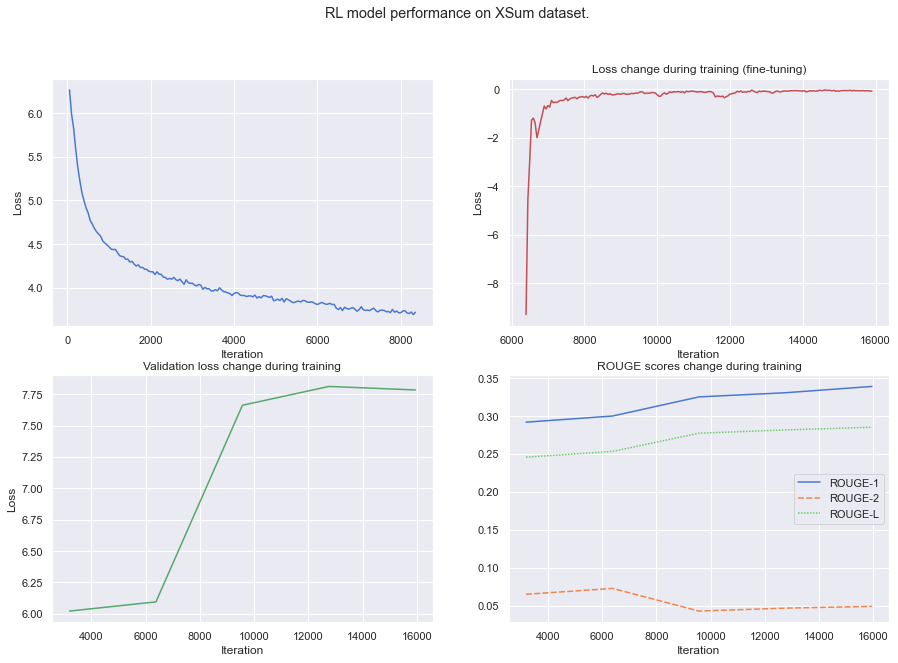

In [7]:
logs_path = Path('../data/saved/logs')
plot_pointer_generator_performance(logs_path / 'pointer_generator', 'CNN/Daily Mail')
plot_pointer_generator_performance(logs_path / 'pointer_generator-xsum', 'XSum', use_full_validation=True)
plot_transformer_performance(logs_path / 'transformer', 'CNN/Daily Mail')
plot_transformer_performance(logs_path / 'transformer', 'XSum')
plot_rl_performance(logs_path / 'reinforcement_learning', 'CNN/Daily Mail', use_full_validation=True)
plot_rl_performance(logs_path / 'reinforcement_learning-xsum', 'XSum', use_full_validation=True)